In [45]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
import json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
sw_nltk.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
import re
import spacy
import os

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

#from lda_classification.model import TomotopyLDAVectorizer
#from lda_classification.preprocess.spacy_cleaner import SpacyCleaner
import gensim
import gensim.corpora as corpora
import pyLDAvis
#import pyLDAvis.gensim_models as gensim
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim
import pickle 

from matplotlib import pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project
use_umap = False #make this True if you want to use UMAP for your visualizations
#min_df = 5 #Minimum number for document frequency in the corpus
#rm_top = 5 #Remove top n frequent words



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#lem for lemmatization, stem for stemmatizing
def preprocess(data, type="lem"):
    words = set(nltk.corpus.words.words())
    i = 0
    preprocessed_data = []
    for x in data:
        #Lowerize
        x = x.lower()
        #Eliminate special characters
        x = re.sub(r'\d+', '', x)
        x = re.sub(' +', ' ', x.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\\|'`~-=_+"}).strip())
        
        #Eliminate stop words
        words = [word for word in x.split() if word not in sw_nltk] 
        x = " ".join(words)

        #Stemming / Lemmatizing
        words = word_tokenize(x)
        rootWords = []
        if type=='stem':
                ps = PorterStemmer()
                rootWords.append(ps.stem(w))
        else:
            for w in words:
                wordnet_lemmatizer = WordNetLemmatizer()
                rootWords.append(wordnet_lemmatizer.lemmatize(w))

        x = x.split(' ')
        #x = TreebankWordDetokenizer().detokenize(rootWords)

        nlp = spacy.load("en_core_web_sm")
        
        article = []
        for sent in x:
            doc = nlp(sent)
            j = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
            
            if (j != []):
                #print(j)
                #print(j[0] in words)
                #print(j[0].isalpha())
                if((j[0] in words) or (j[0].isalpha())):
                    article.append(j[0])
        dropped_documents = []
        if article != []:
            preprocessed_data.append(article)
        else:
            dropped_documents.append(article)
            print('Dropped ', i)
        
        i = i + 1
        #print(article)
    return preprocessed_data, dropped_documents
        
    


#preprocess(['Hsf##123 14: . ; ,  45', 'Blu34%& 22', 'as fine as good', 'found, find, go, went', 'studies studying cries cry'])

In [3]:
#Carefull!!! Takes about 90 minutes! If you already have a model saved, then use the prep_arr() class!!!!


# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

dropped_documents = []
dropped = []

prep_collection = []
for x in collection:
    prep_collection.append(x['text'])
prep_collection, dropped = preprocess(prep_collection)
dropped_documents.append(dropped)
dropped = []

prep_queries = []
for x in queries:
    prep_queries.append(x['text'])
prep_queries, drop = preprocess(prep_queries)
dropped_documents.append(dropped)
dropped = []

#print(prep_queries)
#print(prep_collection)

Dropped  1353
Dropped  7850


In [46]:
# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

In [47]:
#Savable data array class


class prep_arr(object):
    def __init__(self, data_arr=[]):
        self.data_arr = data_arr

    def save(self, path):
        with open(path, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)

    def load(self, path):
        with open(path, 'rb') as inp:
            prep_arr_load = pickle.load(inp)
        self.data_arr = prep_arr_load.data_arr
    

In [5]:
#Crfeate querry collection ensemble
querries_collection_dataset = []
for x in prep_queries:
    querries_collection_dataset.append(x)
for x in prep_collection:
    querries_collection_dataset.append(x)

In [6]:
#Save cleaned arrays

arr_q = prep_arr(prep_queries)
arr_q.save("./cleaned_data/prep_queries.txt")
arr_c = prep_arr(prep_collection)
arr_c.save("./cleaned_data/prep_collection.txt")

arr_qc = prep_arr(querries_collection_dataset)
arr_qc.save("./cleaned_data/querries_collection_dataset.txt")

In [48]:
print(len(prep_queries))
print(len(prep_collection))
print(len(querries_collection_dataset))
print(len(dropped_documents))

50
7848
7898
3


In [49]:
#Load the saved arrays

load_q = prep_arr()
load_q.load("./cleaned_data/prep_queries.txt")
prep_queries = load_q.data_arr

load_c = prep_arr()
load_c.load("./cleaned_data/prep_collection.txt")
prep_collection = load_c.data_arr

load_qc = prep_arr()
load_qc.load("./cleaned_data/querries_collection_dataset.txt")
querries_collection_dataset = load_qc.data_arr

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

def detokenize(dataset):
    detokenized_dataset = []
    for t in dataset:
        text = ""
        for w in t:
            text = text + w + " "
        detokenized_dataset.append(text.rstrip())

    #print(detokenized_dataset)
    return detokenized_dataset

def tf_idf_cleaner(dataset, tf_idf_scores, min_score):
    clean_dataset = []
    dropped_documents = []
    i = 0
    for text in dataset:
        t = []
        for word in text:
            if word in tf_idf_scores.columns:
                score = tf_idf_scores.iloc[i][word]
                if (score >= min_score):
                    t.append(word)
        if t != []:
            clean_dataset.append(t)
        else:
            print('empty text on line ', i)
            dropped_documents.append(i)
        i = i + 1
    #print(clean_dataset)
    return clean_dataset, dropped_documents




def tf_idf(dataset, min_score=0):
    dataset_detokenized = detokenize(dataset)
    #vec=TfidfVectorizer(stop_words='english')
    ##Create Vectors
    #matrix=vec.fit_transform(dataset)
    #print("Feature Names n",vec.get_feature_names_out())
    #print(matrix[0].toarray())
    #print("Sparse Matrix n",matrix.shape,"n",matrix.toarray())


    countvectorizer = CountVectorizer(analyzer= 'word')
    tfidfvectorizer = TfidfVectorizer(analyzer='word')
    count_wm = countvectorizer.fit_transform(dataset_detokenized)
    tfidf_wm = tfidfvectorizer.fit_transform(dataset_detokenized)
    count_tokens = countvectorizer.get_feature_names()
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

    #print("Count Vectorizer\n")
    #print(df_countvect)
    #print("\nTF-IDF Vectorizer\n")
    #print(df_tfidfvect)
    #df_tfidfvect.to_csv('tfidf.csv')

    if(min_score > 0):
        dataset, dropped_documents = tf_idf_cleaner(dataset,df_tfidfvect,min_score)

    return dataset, df_countvect, df_tfidfvect, dropped_documents

    #terms = countvectorizer.fit_transform(dataset_detokenized)
    #term_vectors  = countvectorizer.transform(dataset_detokenized)
    #print("Sparse Matrix form of test data : \n")
    #print(term_vectors.todense())

    #tfidf = TfidfTransformer(norm='l2')
    #term_vectors.todense()
    #tfidf.fit(term_vectors)
    #tf_idf_matrix = tfidf.transform(term_vectors)
    #print("\nVector of idf \n")
    #print(tfidf.idf_)
    #print("\nFinal tf-idf vectorizer matrix form :\n")
    #print(tf_idf_matrix.todense())


querries_collection_dataset, df_countvect, df_tfidfvect, dropped = tf_idf(querries_collection_dataset, min_score=0.2)
dropped_documents.append(dropped)
prep_collection = querries_collection_dataset[50:]
prep_querries = querries_collection_dataset[:50]

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


empty text on line  2857


In [10]:
print(len(dropped_documents))

3


In [51]:
# Create Dictionary
id2word = corpora.Dictionary(querries_collection_dataset)
# Create Corpus
texts = querries_collection_dataset
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


In [52]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"information" + 0.011*"field" + 0.010*"network" + 0.008*"system" + '
  '0.007*"electron" + 0.007*"book" + 0.007*"filter" + 0.006*"datum" + '
  '0.006*"school" + 0.006*"amplifier"'),
 (1,
  '0.014*"library" + 0.009*"frequency" + 0.007*"amplifier" + 0.007*"wave" + '
  '0.007*"information" + 0.006*"language" + 0.006*"university" + '
  '0.005*"circuit" + 0.005*"function" + 0.004*"service"'),
 (2,
  '0.014*"information" + 0.009*"datum" + 0.009*"library" + 0.008*"circuit" + '
  '0.006*"pulse" + 0.006*"computer" + 0.006*"layer" + 0.006*"catalogue" + '
  '0.005*"electron" + 0.005*"magnetic"'),
 (3,
  '0.025*"system" + 0.012*"information" + 0.009*"service" + 0.006*"amplifier" '
  '+ 0.006*"noise" + 0.005*"frequency" + 0.005*"circuit" + 0.005*"method" + '
  '0.005*"science" + 0.005*"model"')]


In [53]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    #LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.036830 -0.083610       1        1  26.273469
2     -0.073704 -0.014780       2        1  25.376723
1     -0.031108  0.047419       3        1  24.204987
3      0.067983  0.050971       4        1  24.144821, topic_info=           Term        Freq       Total Category  logprob  loglift
15       system  839.000000  839.000000  Default  30.0000  30.0000
115       field  409.000000  409.000000  Default  29.0000  29.0000
111     library  639.000000  639.000000  Default  28.0000  28.0000
741    research  212.000000  212.000000  Default  27.0000  27.0000
69      network  403.000000  403.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
326        book   68.883691  275.826715   Topic4  -5.7702   0.0337
667      region   58.829446  161.068253   Topic4  -5.9280   0.4139
753      filter   63.629580  265.318379   Topic4  -5.8496  -0.0068
3    transistor   59.313006  285.234058   Topic4  -5.9198  -0.1494
105    computer   59.539319  352.609573   Topic4  -5.9160  -0.3576

[359 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1748      1  0.794187            aacr
1748      2  0.204951            aacr
6810      1  0.157763  accountability
6810      4  0.788815  accountability
3932      1  0.938534   administrator
...     ...       ...             ...
920       1  0.176888            year
920       2  0.265332            year
920       3  0.519609            year
920       4  0.033167            year
3302      1  0.938488             zbb

[755 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [54]:
import math
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=prep_collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=querries_collection_dataset)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic_querries = df_dominant_topic[df_dominant_topic['Document_No'] < 50]
#print(df_dominant_topic_querries)

df_dominant_topic_querries = df_dominant_topic_querries[df_dominant_topic_querries['Text'].notna()]
df_dominant_topic_collection = df_dominant_topic[df_dominant_topic['Document_No'] >= 50]
df_dominant_topic_collection = df_dominant_topic_collection[df_dominant_topic_collection['Text'].notna()]

df_dominant_topic = df_dominant_topic[df_dominant_topic['Text'].notna()]

print(df_dominant_topic)
#print(df_dominant_topic_querries['Text'])

      Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0             2.0              0.8431   
1               1             3.0              0.8883   
2               2             3.0              0.7869   
3               3             2.0              0.9515   
4               4             0.0              0.8672   
...           ...             ...                 ...   
7893         7893             2.0              0.9452   
7894         7894             2.0              0.9416   
7895         7895             2.0              0.9363   
7896         7896             0.0              0.5948   
7897         7897             3.0              0.9505   

                                                                                         Keywords  \
0     information, datum, library, circuit, pulse, computer, layer, catalogue, electron, magnetic   
1      system, information, service, amplifier, noise, frequency, circuit, method, science, model   
2      syste

In [15]:
print(len(df_dominant_topic_querries))
print(len(df_dominant_topic_collection))


50
7848


In [55]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9834,"information, field, network, system, electron, book, filter, datum, school, amplifier","[index, file, secondary, index, file, file, secondary, key, key, secondary, index, bucket, key, ..."
1,1.0,0.9859,"library, frequency, amplifier, wave, information, language, university, circuit, function, service","[programming, style, functional, style, program, programming, language, style, programming, prog..."
2,2.0,0.9813,"information, datum, library, circuit, pulse, computer, layer, catalogue, electron, magnetic","[language, constraint, datum, access, control, share, access, control, extend, language, control..."
3,3.0,0.9899,"system, information, service, amplifier, noise, frequency, circuit, method, science, model","[datum, communication, control, procedure, datum, communication, datum, communication, control, ..."


In [68]:
pddf = pd.DataFrame({'Data':[0,1,2,3,4,5,6,7,8,9,10]})
print(pddf.iloc[:3])
print(pddf.iloc[3:])

   Data
0     0
1     1
2     2
    Data
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10


In [66]:
# Querries and Collection
## 50 + 7851 = 7901
# Dropped: 1353, 7850, 2857]

#print(df_countvect[1351:1354][0:4])

#print(df_countvect[1353:1355][0:4])

def restore_eliminated_rows(df, positions_tf_idf, positions_prep):
    if positions_tf_idf != []:
        for pos in positions_tf_idf:
            df1 = df.iloc[:pos]
            df3 = df.iloc[pos:]
            df2 = pd.DataFrame(columns = df_countvect.columns)
            df2.loc[0] = 0
            frames = [df1, df2, df3]
            df = pd.concat(frames).reset_index()

    if positions_prep != []:
        print(positions_prep)
        for pos in positions_prep:
            print(pos)
            df1 = df.iloc[:pos]
            df3 = df.iloc[pos:]
            df2 = pd.DataFrame(columns = df_countvect.columns)
            df2.loc[0] = 0
            frames = [df1, df2, df3]
            df = pd.concat(frames).reset_index(drop=True)

    return df

df_countvect_restored = restore_eliminated_rows(df_countvect, [], [1353, 7850])
df_tfidfvect_restored = restore_eliminated_rows(df_tfidfvect, [], [1353, 7850])
print(len(df_countvect_restored))
print(len(df_tfidfvect_restored))

[1353, 7850]
1353
7850
[1353, 7850]
1353
7850
7901
7901


In [70]:
print(queries)

[{'recordId': 245, 'text': 'transistor phase splitting circuits', 'labels': ['physics', 'electrical engineering']}, {'recordId': 891, 'text': 'the determination of the orbits of individual meteors by radio methods', 'labels': ['physics', 'astronomics']}, {'recordId': 1217, 'text': 'articles on text formatting systems, including "what you see is what you get" systems. examples: t/nroff, scribe, bravo.', 'labels': ['computer sciences']}, {'recordId': 1741, 'text': 'i am interested in cognitive models of library use. what studies or articles are there looking at the psychology of library and information use, i.e. strategies of seeking, information and the way its usefulness is perceived. use of libraries, library materials, user behaviour, information seeking behaviour or use, usefulness, psychology of library and information use, library user, user satisfaction.', 'labels': ['computer sciences', 'psychology']}, {'recordId': 2405, 'text': 'memory management aspects of operating systems', 

In [56]:
df_results = pd.DataFrame({'Query ID', 'Iteration', 'Dok.Nummer', 'Rang', 'System'})
i = 0
while i < len(queries):
    j = 0




dropped_documents = [1353, 7850, 2857]
#print(collection[:100])
print('Queries ', len(queries))
print('Collection ', len(collection))
print('Querries + Collection ', len(querries_collection_dataset))
print('Count Vectors ', len(df_countvect))
print('tf-idf Vectors ', len(df_tfidfvect))

print('Dropped Documents ', len(dropped_documents))

print('Prep_collection ', len(prep_collection))
print('Prep_Queries ', len(prep_querries))
print('Dominant Topics ', len(df_dominant_topic))

print(dropped_documents)

print(len(df_countvect.columns))


#queries
#collection


#querries_collection_dataset (TFIDF Dataset)
#df_countvect
#df_tfidfvect
#dropped_documents

#prep_collection
#prep_querries

#df_dominant_topic

Queries  50
Collection  7851
Querries + Collection  7898
Count Vectors  7899
tf-idf Vectors  7899
Dropped Documents  3
Prep_collection  7848
Prep_Queries  50
Dominant Topics  7898
[1353, 7850, 2857]
12868


In [17]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=prep_collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=querries_collection_dataset)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8412,"library, information, field, school, pm, circuit, system, electron, university, function","[transistor, phase, splitting, circuit]"
1,1,1.0,0.8829,"system, information, electron, magnetic, book, circuit, noise, computer, solar, oscillator","[determination, orbit, individual, meteor, radio, method]"
2,2,1.0,0.9197,"system, information, electron, magnetic, book, circuit, noise, computer, solar, oscillator","[article, text, format, system, get, system, example, tnroff, scribe]"
3,3,3.0,0.6292,"library, information, field, school, pm, circuit, system, electron, university, function","[psychology, information, seek, information, usefulness, user, behaviour, information, seek, beh..."
4,4,1.0,0.8658,"system, information, electron, magnetic, book, circuit, noise, computer, solar, oscillator","[memory, management, aspect, operate, system]"
...,...,...,...,...,...
95,95,1.0,0.8759,"system, information, electron, magnetic, book, circuit, noise, computer, solar, oscillator","[datum, input, datum, input, computer, input, computer, user, value, computer, converse, user, i..."
96,96,1.0,0.9318,"system, information, electron, magnetic, book, circuit, noise, computer, solar, oscillator","[convention, cosmic, ray, convention, varenna, cosmic, ray, radiation, shower, cosmic, radiation]"
97,97,0.0,0.6227,"information, frequency, service, network, public, research, filter, computer, system, energy","[cable, satellite, library, cable, library, library, cable, company, satellite, cable, library, ..."
98,98,3.0,0.9216,"library, information, field, school, pm, circuit, system, electron, university, function","[campaign, aid, help, lobbyist, great, victory, creation, joint, funding]"


In [19]:
print(len(df_dominant_topic))

7848


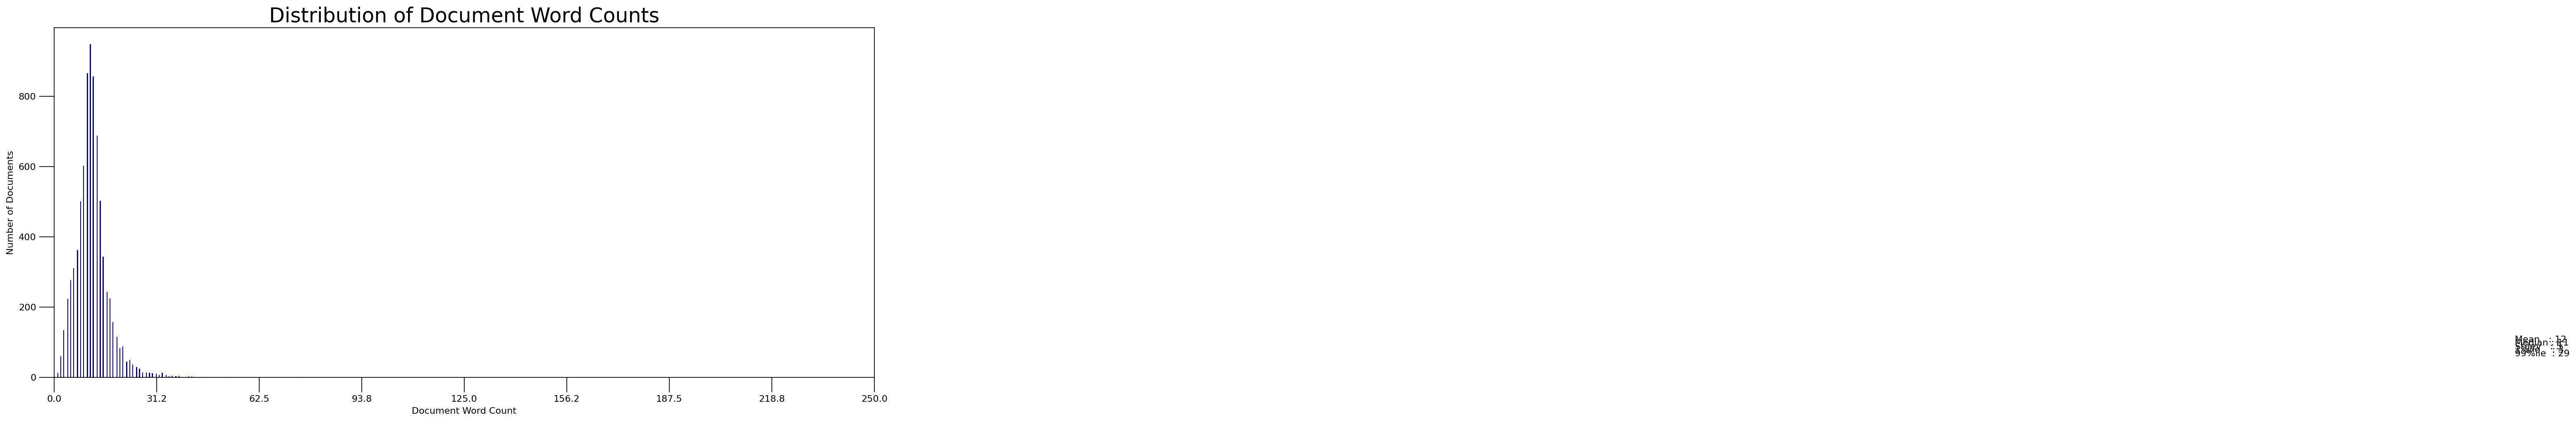

In [18]:
#print([len(d) for d in df_dominant_topic.Text])
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 250, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 250), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,250,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

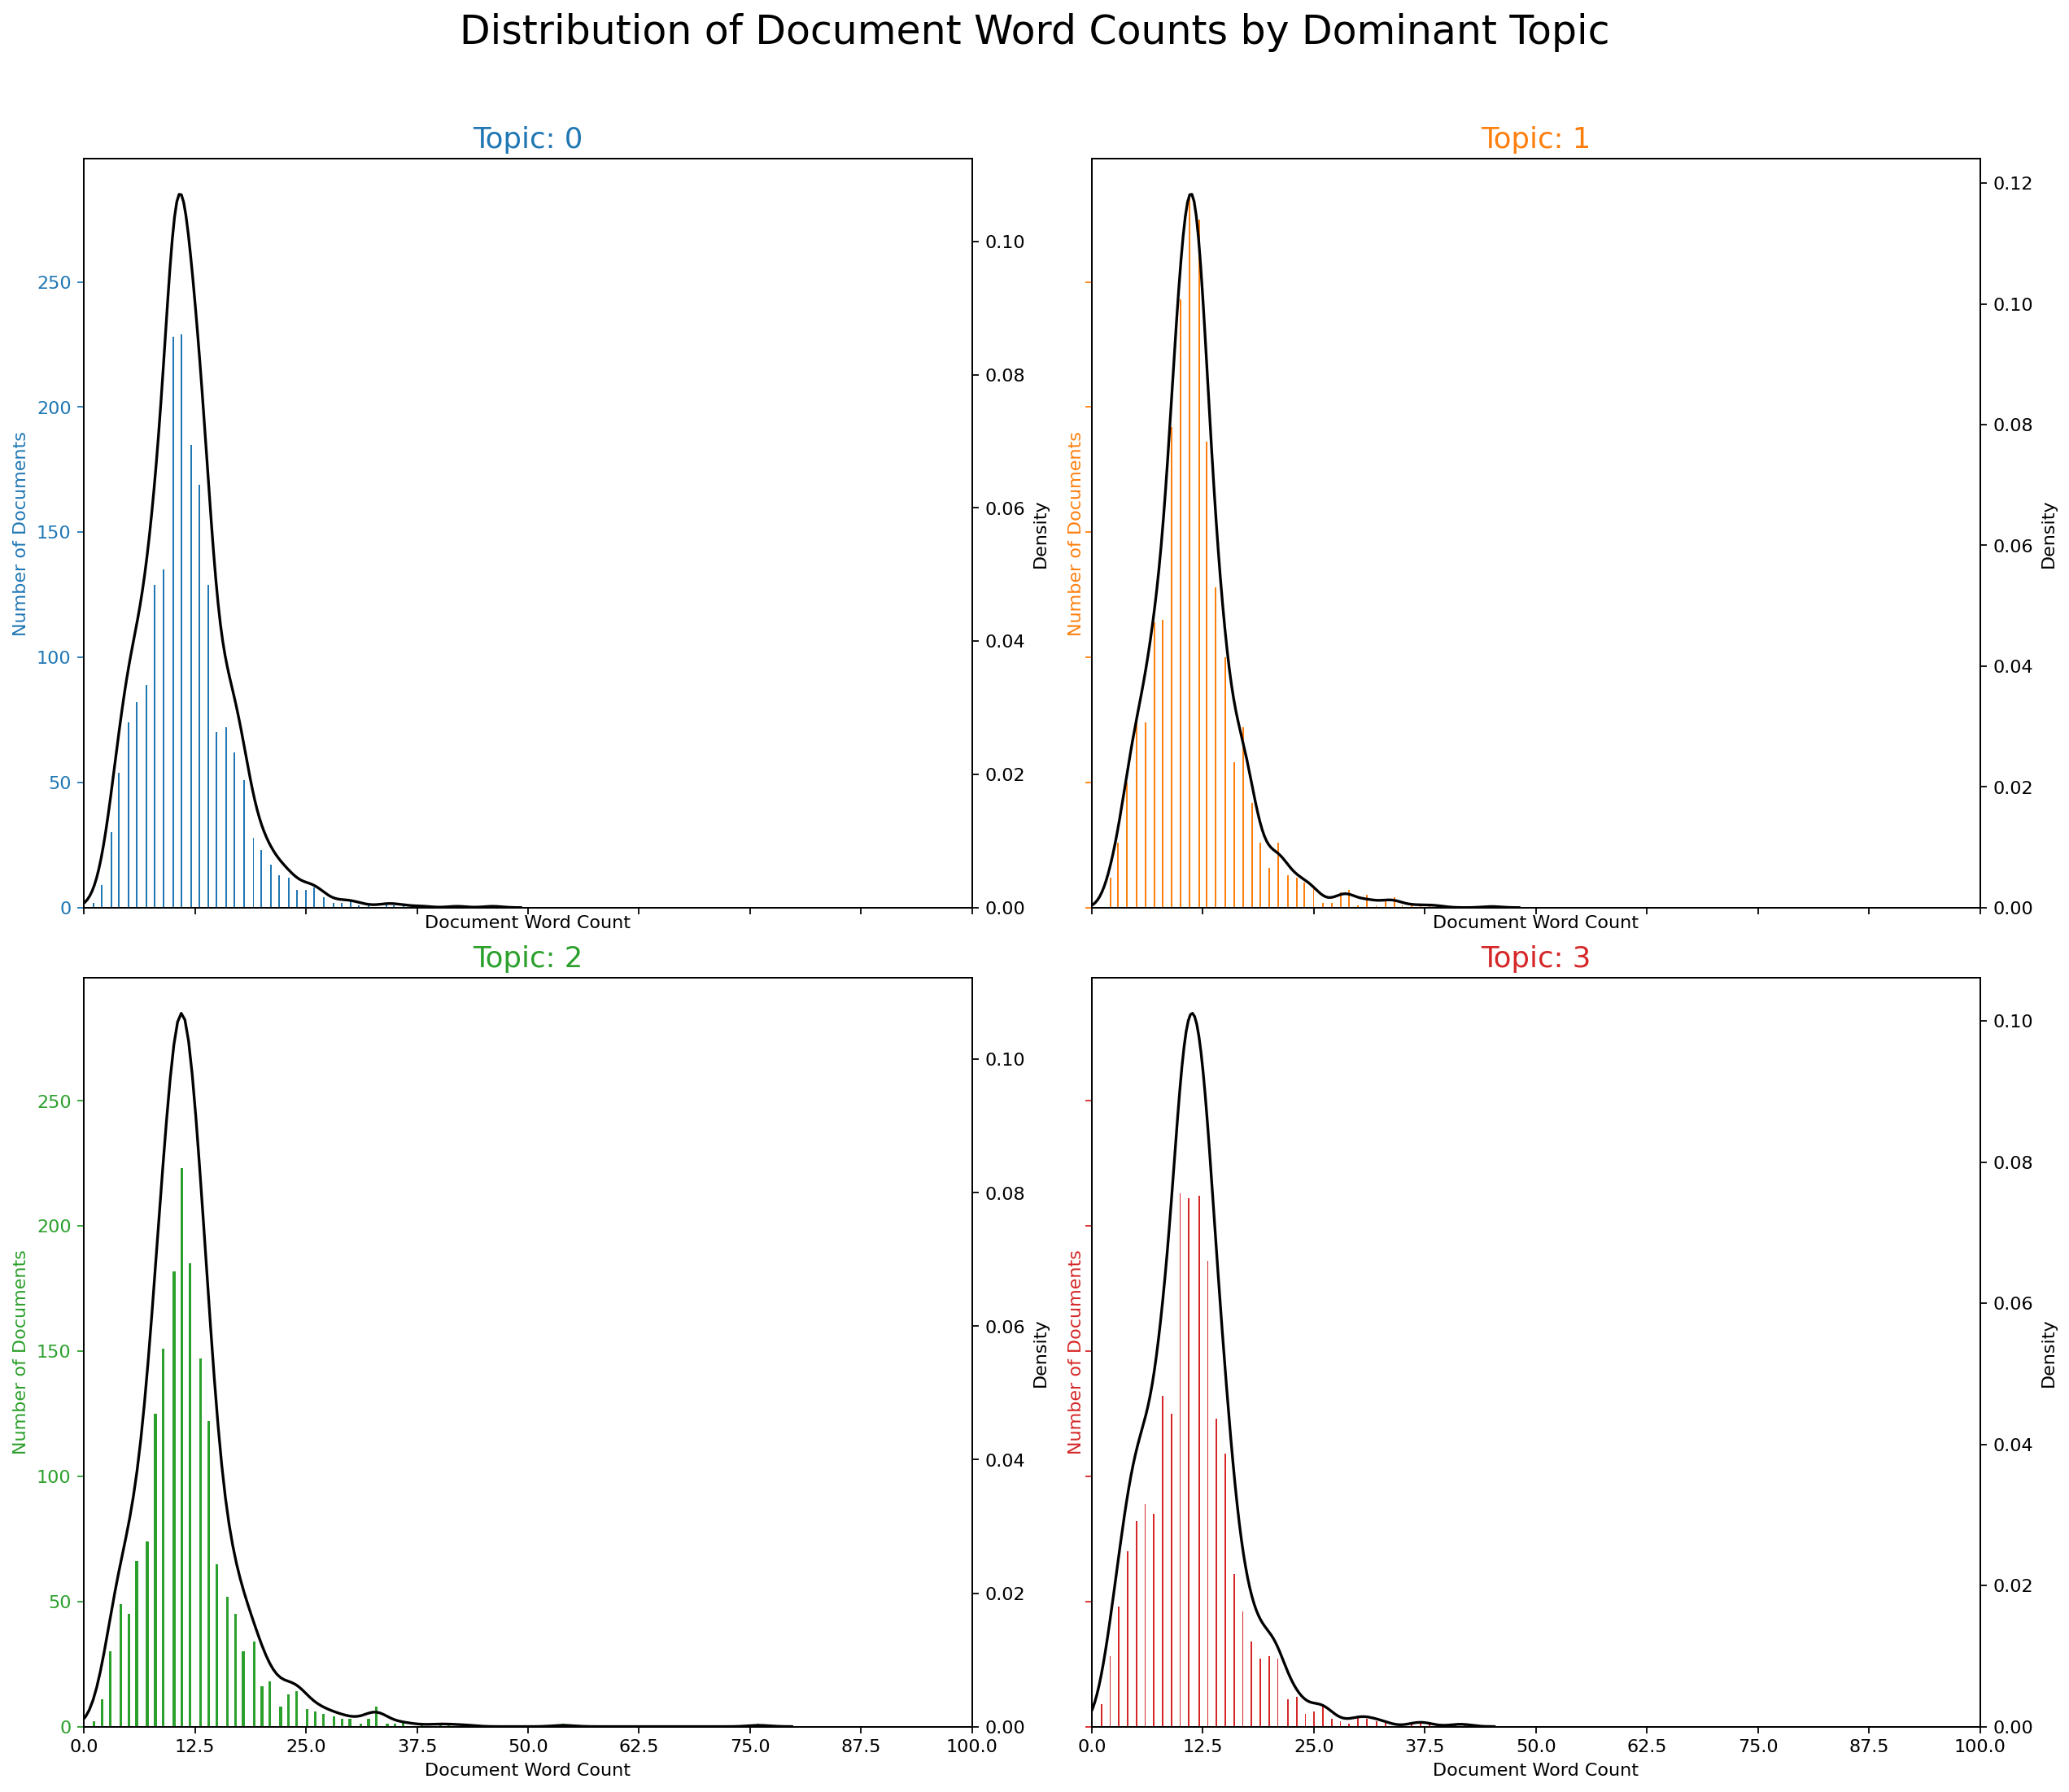

In [19]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(round(num_topics/2),2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 250, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

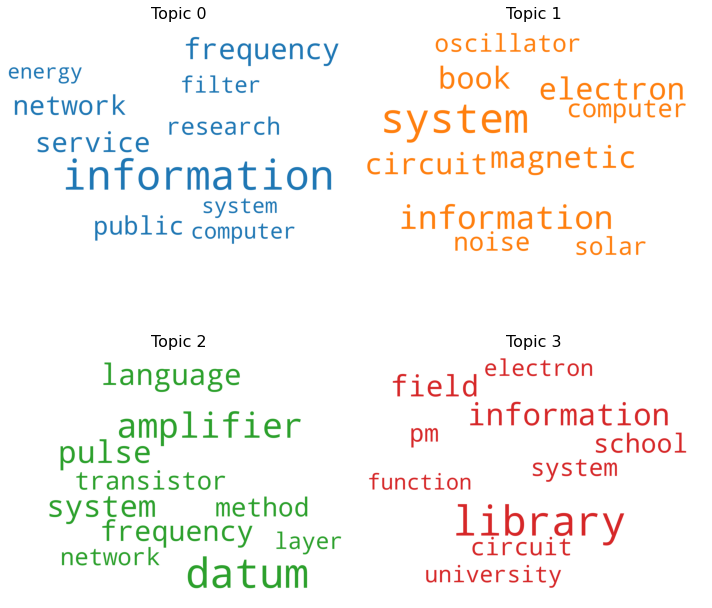

In [20]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\TEMP/ipykernel_25516/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_25516/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_25516/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_25516/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


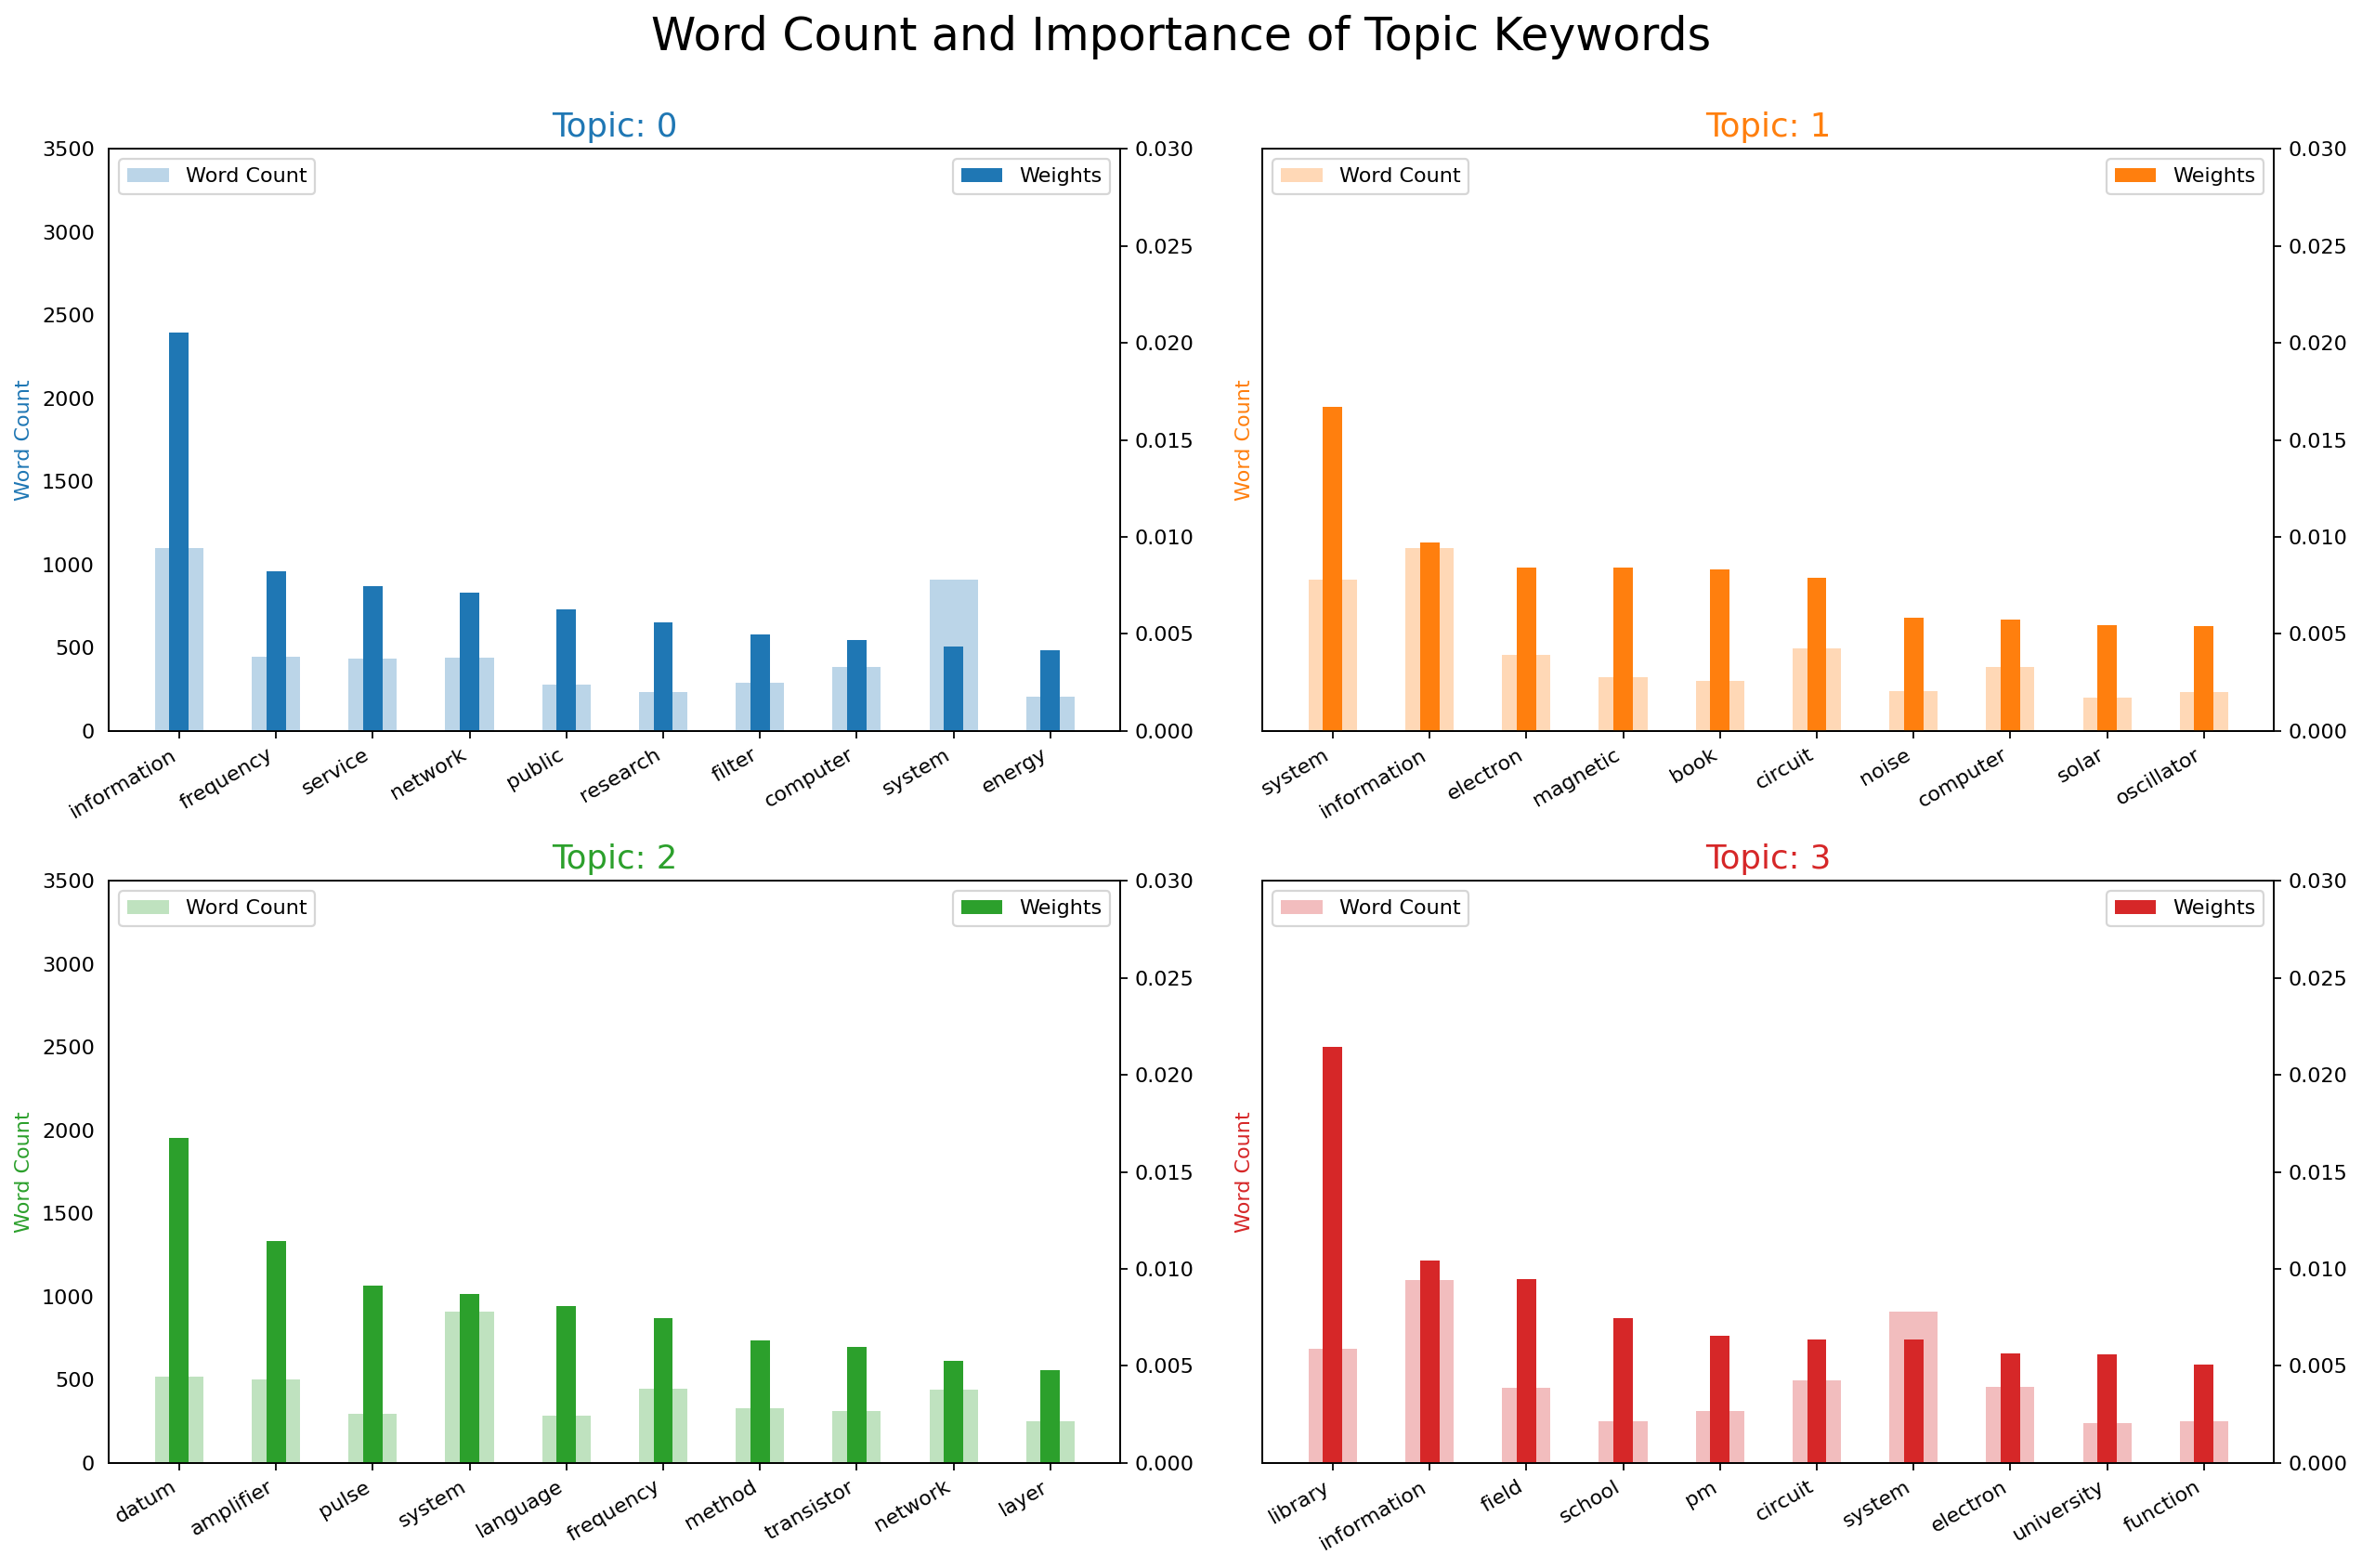

In [21]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_collection for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [22]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
#print(enumerate(lda_model[corpus]))
for i, row_list in enumerate(lda_model[corpus]):
    #print(i, row_list)
    topic_weights.append([w for w in row_list[0]])
#topic_weights = np.array(topic_weights)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
print(arr)
# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
#tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[[0.         0.05307741]
 [0.         0.04050462]
 [0.         0.02803972]
 ...
 [0.         0.93235397]
 [0.         0.02300424]
 [0.         0.01656087]]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7898 samples in 0.005s...
[t-SNE] Computed neighbors for 7898 samples in 0.173s...


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 7898
[t-SNE] Computed conditional probabilities for sample 2000 / 7898
[t-SNE] Computed conditional probabilities for sample 3000 / 7898
[t-SNE] Computed conditional probabilities for sample 4000 / 7898
[t-SNE] Computed conditional probabilities for sample 5000 / 7898
[t-SNE] Computed conditional probabilities for sample 6000 / 7898
[t-SNE] Computed conditional probabilities for sample 7000 / 7898
[t-SNE] Computed conditional probabilities for sample 7898 / 7898
[t-SNE] Mean sigma: 0.000046


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.447727
[t-SNE] KL divergence after 1000 iterations: 0.401427


Loading BokehJS ...

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

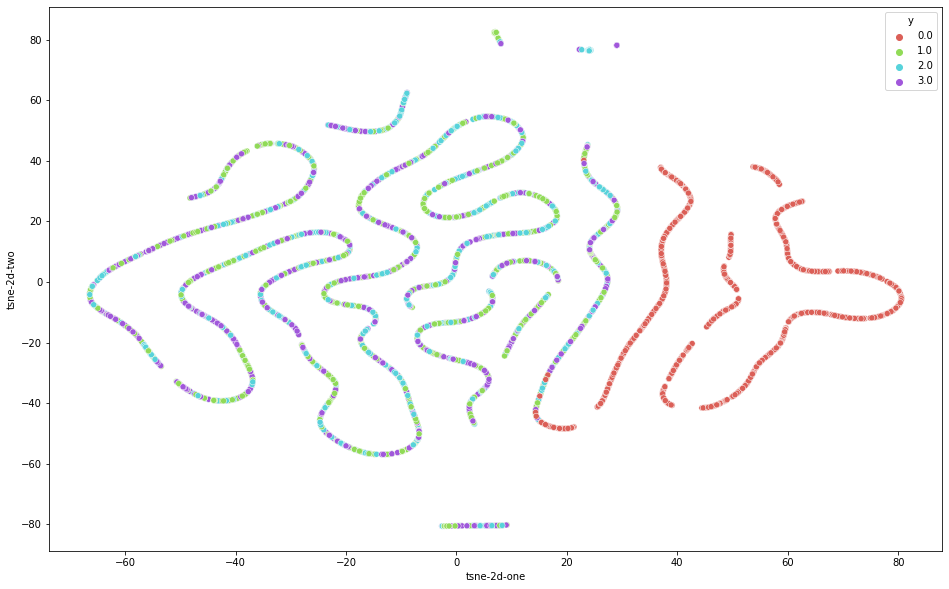

In [23]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_lda[:,0]
df_subset['tsne-2d-two'] = tsne_lda[:,1]
df_subset['y'] = df_dominant_topic['Dominant_Topic']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", num_topics),
    data=df_subset,
    legend="full",
    alpha=0.99
)
